In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import timm

from torchvision import transforms
from PIL import Image
from dataset import FacialLandmarkDataset

In [2]:
class FLDModel(nn.Module):
    def __init__(self, vit_model_name='vit_base_patch16_224'):
        super(FLDModel, self).__init__()
        # Load pre-trained ViT model
        self.vit = timm.create_model(vit_model_name, pretrained=True)
        
        # Remove the classification head
        self.vit.head = nn.Identity()
        
        # Custom head for facial landmark detection
        self.fc1 = nn.Linear(self.vit.num_features, 256)  # Example dimensions
        self.fc2 = nn.Linear(256, 68 * 2)  # 68 landmarks with x and y coordinates
    
    def forward(self, x):
        # Extract features from ViT
        features = self.vit(x)
        
        # Pass through the custom head
        x = torch.relu(self.fc1(features))
        landmarks = self.fc2(x)
        
        return landmarks

In [3]:
# Define the transformations for ViT input
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [4]:
dataset = FacialLandmarkDataset(root_dir='archive/ibug_300W_large_face_landmark_dataset/afw', transform=preprocess)

In [5]:
# Load the first image and its corresponding landmarks
img, landmarks = dataset.__getitem__(19)

In [6]:
# Convert the image tensor to a NumPy array for plotting
img_for_plotting = img.permute(1, 2, 0).numpy()  # Change from (C, H, W) to (H, W, C)

# Normalize image for plotting
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
img_for_plotting = img_for_plotting * std + mean  # Denormalize
img_for_plotting = np.clip(img_for_plotting, 0, 1)  # Ensure values are in [0, 1]

# Load the model
model = FLDModel()
model.load_state_dict(torch.load('best_model.pth'))
model.to('cuda' if torch.cuda.is_available() else 'cpu')
model.eval()  # Set the model to evaluation mode

<ipython-input-6-dc6fb3324315>:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


FLDModel(
  (vit): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (patch_drop): Identity()
    (norm_pre): Identity()
    (blocks): Sequential(
      (0): Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (q_norm): Identity()
          (k_norm): Identity()
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): Identity()
        (drop_path1): Identity()
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (act): GELU(approximate='none')
     

In [7]:
# Prepare the image for prediction
image_tensor = img.unsqueeze(0).to('cuda' if torch.cuda.is_available() else 'cpu')

# Make predictions
with torch.no_grad():
    outputs = model(image_tensor)
    outputs = outputs.view(-1, 68, 2)  # Reshape to match landmarks format

# Convert outputs to numpy
predicted_landmarks = outputs.cpu().numpy().reshape(68, 2)

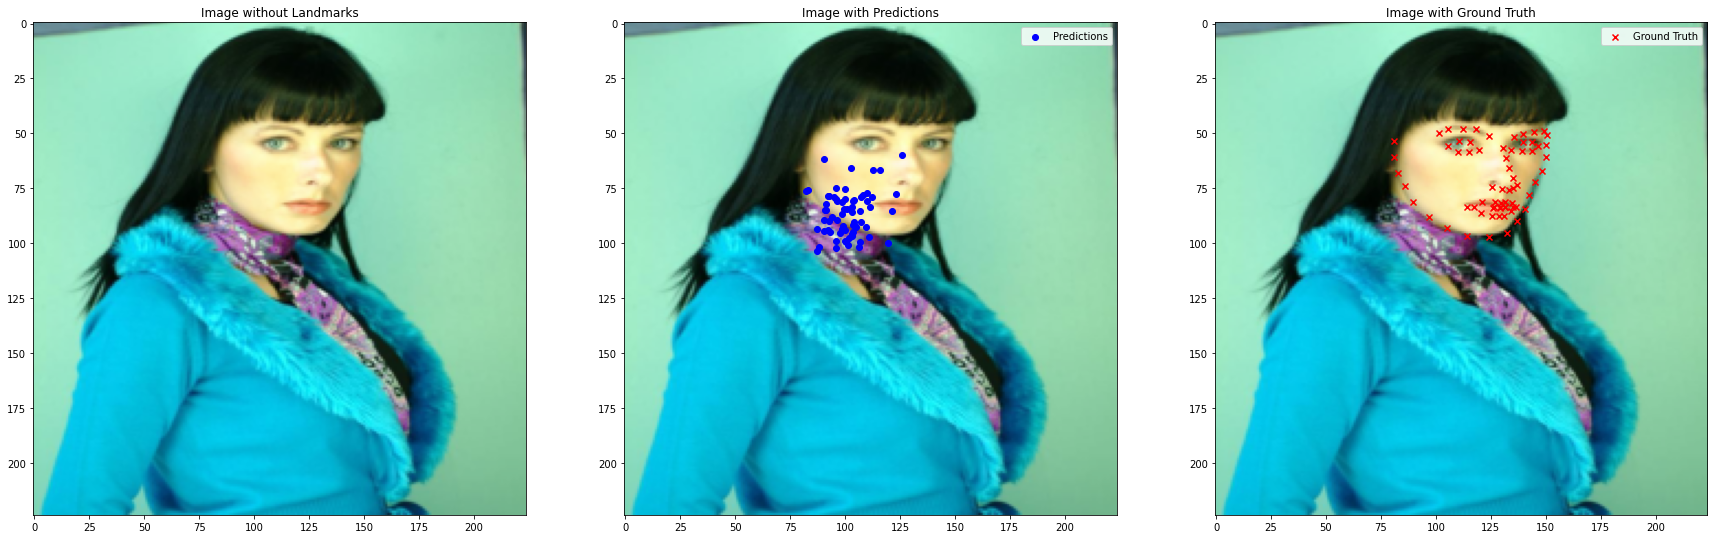

In [8]:
# Check landmarks tensor shape
if landmarks.ndim == 1:
    landmarks = landmarks.view(68, 2)  # Reshape if necessary

plt.figure(figsize=(30, 10))

# Plot image without landmarks
plt.subplot(1, 3, 1)
plt.imshow(img_for_plotting)
plt.title('Image without Landmarks')

# Plot image with predictions
plt.subplot(1, 3, 2)
plt.imshow(img_for_plotting)
plt.scatter(predicted_landmarks[:, 0], predicted_landmarks[:, 1], c='b', marker='o', label='Predictions')
plt.title('Image with Predictions')
plt.legend()

# Plot image with ground truth and predictions
plt.subplot(1, 3, 3)
plt.imshow(img_for_plotting)
plt.scatter(landmarks[:, 0], landmarks[:, 1], c='r', marker='x', label='Ground Truth')
plt.title('Image with Ground Truth')
plt.legend()

plt.show()